# ORIE 5355 HW 3: Algorithmic Pricing

 - Name: Saketh Pabolu
 - Net-id: smp382
 - Date: Oct 21, 2025
 - Late days used for this assignment: 1
 - Total late days used (counting this assignment): 1
 - People with whom you discussed this assignment: N/A

After you finish the homework, please complete the following (short, anonymous) post-homework survey: https://forms.gle/NYYpiyK1XoqzrNzY8 and include the survey completion code below.

### Question 0 [1 point]
<font color='green'> Survey completion code: 

hw3_2021xyz

We have marked questions in <font color='green'> green </font>. Please put answers in black (do not change colors). You'll want to write text answers in "markdown" mode instead of code. In Jupyter notebook, you can go to Cell > Cell Type > Markdown, from the menu. Please carefully read the late days policy and grading procedure [here](https://orie5355.github.io/Fall_2025/assignments/). 

# Conceptual component [4 points]

Please complete the following pricing ethics scenario questionnaire: https://forms.gle/ByFDym6ggDiUE6bB9, and include the survey completion code below. **We will discuss these issues in class on 10/22. You must complete the questionnaire before the day of that class, even if you turn in the rest of the homework later. The questionnaire will close the morning of the class that we discuss these issues.**

<font color='green'> Survey completion code: 

<font color='green'> Based on the first letter of your first name, explain your answers to the following questions, in at most three sentences each.

First letter A-C: 1, 6, 11, 16

First letter D-H: 2, 7, 12, 17

First letter I-M: 3, 8, 13, 18

First letter N-S: 4, 9, 14, 19

First letter T-Z: 5, 10, 15, 20


<font color='green'> 

Give and discuss your answers for the 4 questions in this notebook, to be turned in with the rest of the homework. Also be prepared to discuss your answers to at least these questions in class (I might randomly call on people), but you should also be willing/able to discuss your answers to other questions. 

# Programming component

## Helper code

In [1]:
import numpy as np
import pandas as pd
import os, sys, math
import matplotlib.pyplot as plt

In [2]:
df_train = pd.read_csv('HW3_data_train.csv')
test_demand_curve = pd.read_csv('test_demand.csv')

In [3]:
df_train.head()

,Location,Income,Offered price,Purchased
0,Africa,10.38,3.16,False
1,Europe,26.33,3.47,True
2,Europe,24.06,3.78,True
3,Africa,16.18,3.74,False
4,Asia Pacific,13.73,4.75,False


In [4]:
df_train.shape, test_demand_curve.shape

((4000, 4), (199, 5))

## Problem 1: Demand estimation and pricing without covariates

First, we will use the training data to construct estimates of the demand at each price without leveraging the covariates, and then use that estimated function to calculate optimal prices. 

### 1a) Naive method: empirical estimate of demand $d(p)$ at each price

<font color='green'> Fill in the below function, that takes in a dataframe and the number of bins into which to separate the historical prices. The function should output a dataframe that has one row for each price bin, with two columns: the bin interval, and the estimated demand $d(p)$ (the fraction of potential customers who purchase at price $p$) in that bin.  
    
Use the following function to create bins:
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.qcut.html

In [5]:
# Example with 10 bins:
df_train['bin_with_10_bins'] = pd.qcut(df_train['Offered price'], 10)
df_train.head()

,Location,Income,Offered price,Purchased,bin_with_10_bins
0,Africa,10.38,3.16,False,"(2.95, 3.54]"
1,Europe,26.33,3.47,True,"(2.95, 3.54]"
2,Europe,24.06,3.78,True,"(3.54, 4.19]"
3,Africa,16.18,3.74,False,"(3.54, 4.19]"
4,Asia Pacific,13.73,4.75,False,"(4.19, 4.77]"


For example, with 2 bins and passing in df_train to the function, you should see the following output:

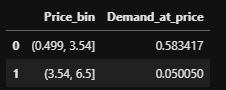

(If you can't see the image, then it is an image with 2 columns (Price_bin and Demand_at_price), and two rows. The First row has price bin (.499, .354] and Demand_at_price equal to .583.)

In [6]:
def create_empirical_estimate_demand_df(df, number_of_pricing_bins):
    """
    Returns a dataframe with one row per price bin and columns:
      - Price_bin (Interval)
      - Demand_at_price (mean purchase rate in that bin)
    """
    # bin by price into quantile bins (drop duplicates if prices tie)
    bins = pd.qcut(df['Offered price'], number_of_pricing_bins, duplicates='drop')
    tmp = df.copy()
    tmp['_bin'] = bins

    out = (tmp.groupby('_bin')['Purchased']
               .mean()
               .reset_index()
               .rename(columns={'_bin': 'Price_bin', 'Purchased': 'Demand_at_price'}))

    # edges/midpoints
    out['bin_left']  = [float(iv.left) for iv in out['Price_bin']]
    out['bin_right'] = [float(iv.right) for iv in out['Price_bin']]
    out['bin_mid']   = (out['bin_left'] + out['bin_right']) / 2.0
    return out

<font color='green'> Fill in the below function, that takes in a single price and your empirical df from the above function and outputs the prediction for the demand $d(p)$ at that price. For example, with 2 bins, at price = 3 the function should output 0.583417.

If the price is lower than the smallest bin, then use the value of the smallest bin. If it is higher than the highest bin, use the value of the highest bin.

In [7]:
def get_prediction_empirical(empirical_df, price):
    """
    For a given price, return the demand estimate from the bin the price falls into.
    If price is below/above observed bins, clamp to the first/last bin value.
    """
    intervals = pd.IntervalIndex(empirical_df['Price_bin'].tolist())
    idx = intervals.get_indexer([price])[0]

    if idx == -1:
        # price outside range: clamp to nearest bin
        if price < intervals[0].left:
            return float(empirical_df.iloc[0]['Demand_at_price'])
        else:
            return float(empirical_df.iloc[-1]['Demand_at_price'])

    return float(empirical_df.iloc[idx]['Demand_at_price'])


In [8]:
prices_to_predict = np.linspace(min(df_train['Offered price']), max(df_train['Offered price']), 200)

<font color='green'> Plot in a single figure the outputs of your function as a line plot -- where the X axis corresponds to prices in `prices_to_predict` and the Y axis the predicted Demand at that price -- for the following three inputs to the function:
    
    1. the dataframe is the first 100 rows of df_train, with 10 bins.
    
    2. the dataframe is the first 500 rows of df_train, with 10 bins.
    
    3. the dataframe is all the rows of df_train, with 10 bins.

<font color='green'> In the same figure, include the "true" test-time demand curve, using `test_demand_curve` that we loaded at the top of the homework -- plot the mid-point of each bin on the X axis, and the demand for that bin on the Y axis. So your plot will contain 4 curves in total.


/var/folders/w5/hh1wr7mn0n3gglslknzmbp9w0000gn/T/ipykernel_41515/779748852.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = (tmp.groupby('_bin')['Purchased']
/var/folders/w5/hh1wr7mn0n3gglslknzmbp9w0000gn/T/ipykernel_41515/779748852.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = (tmp.groupby('_bin')['Purchased']
/var/folders/w5/hh1wr7mn0n3gglslknzmbp9w0000gn/T/ipykernel_41515/779748852.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the fut

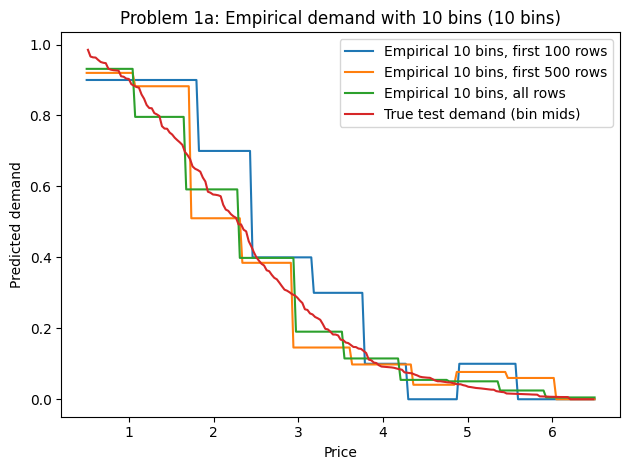

In [9]:
def plot_empirical_curves(bin_count: int, title_suffix: str):
    # three training sizes
    df100 = df_train.iloc[:100]
    df500 = df_train.iloc[:500]
    dfAll = df_train

    # fit empirical curves
    emp100 = create_empirical_estimate_demand_df(df100, bin_count)
    emp500 = create_empirical_estimate_demand_df(df500, bin_count)
    empAll = create_empirical_estimate_demand_df(dfAll, bin_count)

    # predict on the common grid
    y100 = [get_prediction_empirical(emp100, p) for p in prices_to_predict]
    y500 = [get_prediction_empirical(emp500, p) for p in prices_to_predict]
    yAll = [get_prediction_empirical(empAll,  p) for p in prices_to_predict]

    # “True” curve: plot by bin midpoints provided in test_demand_curve
    if 'Price_bin_mid' in test_demand_curve.columns:
        tx = test_demand_curve['Price_bin_mid'].to_numpy()
    else:
        # fallback if only low/high are present
        tx = ((test_demand_curve['Price_bin_low'] + test_demand_curve['Price_bin_high'])/2.0).to_numpy()
    ty = test_demand_curve['Demand_at_price'].to_numpy()

    plt.figure()
    plt.plot(prices_to_predict, y100, label=f'Empirical {bin_count} bins, first 100 rows')
    plt.plot(prices_to_predict, y500, label=f'Empirical {bin_count} bins, first 500 rows')
    plt.plot(prices_to_predict, yAll, label=f'Empirical {bin_count} bins, all rows')
    plt.plot(tx, ty, label='True test demand (bin mids)')
    plt.xlabel('Price')
    plt.ylabel('Predicted demand')
    plt.title(f'Problem 1a: Empirical demand with {bin_count} bins{title_suffix}')
    plt.legend()
    plt.tight_layout()
    plt.show()

# 10 bins
plot_empirical_curves(10, ' (10 bins)')

<font color='green'> Do the same plot, except now you're using 50 bins for each of the three data frames.

/var/folders/w5/hh1wr7mn0n3gglslknzmbp9w0000gn/T/ipykernel_41515/779748852.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = (tmp.groupby('_bin')['Purchased']
/var/folders/w5/hh1wr7mn0n3gglslknzmbp9w0000gn/T/ipykernel_41515/779748852.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = (tmp.groupby('_bin')['Purchased']
/var/folders/w5/hh1wr7mn0n3gglslknzmbp9w0000gn/T/ipykernel_41515/779748852.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the fut

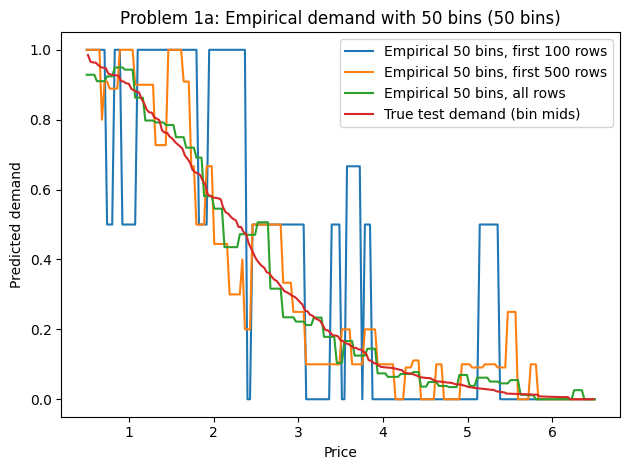

In [10]:
plot_empirical_curves(50, ' (50 bins)')

<font color='green'> Comment on your output in no more than 3 sentences. What is the effect of using more data and more bins?

When you have more data, you can use more bins to get smoother, more reliable demand curves. With limited data like 100 rows, it is better to stick with fewer bins to avoid noisy spikes, but as you collect more observations, we should increase the bins to capture finer details. This is a tradeoff- pair larger datasets with more granular binning, and use simpler binning when data is scarce.

### 1b) Demand estimation using logistic regression

<font color='green'> First, Fill in the below function that fits a logistic regression to predict the probability of purchase at a price ($d(p)$). The logistic regression should just have two coefficients: one for the intercept, and one for the price. The function takes in a dataframe that you will use as your training data for your model, and should return your fitted model. 

Note: the "intercept" term corresponds to a column of all 1s in your dataframe. If you do logistic regression in statsmodels, you can have it add the intercept term for you if you use the formula feature. In sklearn, there is a parameter called fit_intercept. 

In [11]:
from sklearn.linear_model import LogisticRegression

def fit_logistic_regression_demand_just_on_price(df):
    """
    Fits a logistic regression predicting purchase probability from offered price.
    Model has two parameters: intercept and price coefficient.
    """
    X = df[['Offered price']].to_numpy().reshape(-1, 1)
    y = df['Purchased'].astype(int).to_numpy()
    model = LogisticRegression(fit_intercept=True, C=1e6, solver='lbfgs', max_iter=1000)
    model.fit(X, y)
    return model


<font color='green'> Fill in the below function, that takes in a single price and your trained model and outputs the prediction for the demand $d(p)$ at that price.

Note that you do not want to treat logistic regression as a binary classifier that outputs either 0 or 1. Rather, you want to get the probability of being a 1. You can extract this using the predict_proba(X) function. 

In [12]:
def get_prediction_logistic(fitted_model, price):
    """
    Returns predicted probability of purchase (not a 0/1 class label)
    """
    return float(fitted_model.predict_proba(np.array([[price]]))[0, 1])

<font color='green'> For each of the three training dataframes as in part A, fit a model and get the predictions for each of the prices in `prices_to_predict` using your above function. Generate the same lineplot as above. Also include the "true" test-time demand curve, `test_demand_curve`. 

/Users/saketh/Documents/cornell_classes/orie5355/assignments/.venv/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/saketh/Documents/cornell_classes/orie5355/assignments/.venv/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: overflow encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/saketh/Documents/cornell_classes/orie5355/assignments/.venv/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: invalid value encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights


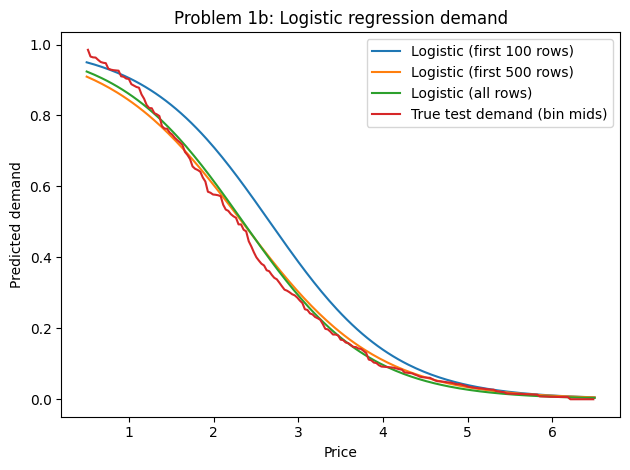

In [13]:
def plot_logistic_curves():
    # training subsets
    df100 = df_train.iloc[:100]
    df500 = df_train.iloc[:500]
    dfAll = df_train

    # fit models
    m100 = fit_logistic_regression_demand_just_on_price(df100)
    m500 = fit_logistic_regression_demand_just_on_price(df500)
    mAll = fit_logistic_regression_demand_just_on_price(dfAll)

    # predicted demand curves
    y100 = [get_prediction_logistic(m100, p) for p in prices_to_predict]
    y500 = [get_prediction_logistic(m500, p) for p in prices_to_predict]
    yAll = [get_prediction_logistic(mAll,  p) for p in prices_to_predict]

    # true demand curve (test set)
    if 'Price_bin_mid' in test_demand_curve.columns:
        tx = test_demand_curve['Price_bin_mid'].to_numpy()
    else:
        tx = ((test_demand_curve['Price_bin_low'] + test_demand_curve['Price_bin_high'])/2.0).to_numpy()
    ty = test_demand_curve['Demand_at_price'].to_numpy()

    # plot
    plt.figure()
    plt.plot(prices_to_predict, y100, label='Logistic (first 100 rows)')
    plt.plot(prices_to_predict, y500, label='Logistic (first 500 rows)')
    plt.plot(prices_to_predict, yAll, label='Logistic (all rows)')
    plt.plot(tx, ty, label='True test demand (bin mids)')
    plt.xlabel('Price')
    plt.ylabel('Predicted demand')
    plt.title('Problem 1b: Logistic regression demand')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_logistic_curves()

<font color='green'> Comment on your output in no more than 3 sentences. What is the effect of using logistic regression instead of the empirical distribution? 

Logistic regression gives you a smooth, stable demand curve that's helpful with small datasets because it imposes structure rather than relying on noisy bins. The downside is that it assumes demand follows a logistic shape, which can bias your estimates if the true demand curve is different. For most practical purposes with limited data, this parametric approach beats binning because it generalizes much better and is easier to interpret. There are also linear and other models we could use, but this one is good for our use case.

### 1c) Optimal pricing using your demand estimates

<font color='green'> Fill in the following function that takes in two lists: a list of prices, and a list of predicted demand d(p) at that price. The function outputs the revenue maximizing price given the data and the corresponding revenue. You may use a "brute force" technique, that loops through all the possible prices and calculates the revenue using that price. 

In [14]:
def get_revenue_maximizing_price_and_revenue(price_options, demand_predictions):
    """
    Given arrays/lists of candidate prices and predicted demand d(p),
    return (price*, revenue*), where revenue* = max_p p * d(p).
    """
    max_revenue = -float('inf')
    best_price = None
    
    for price, demand in zip(price_options, demand_predictions):
        revenue = price * demand
        if revenue > max_revenue:
            max_revenue = revenue
            best_price = price
    
    return float(best_price), float(max_revenue)



# --- 1c(ii): True-demand lookup on the provided test curve ---

def get_true_demand_from_curve_at_price(curve_df: pd.DataFrame, price: float) -> float:
    """
    Finds the test-time demand at a given price using the provided test curve.
    If the curve has explicit bins (low/high), use those; otherwise fall back to nearest midpoint.
    """
    if {'Price_bin_low', 'Price_bin_high'}.issubset(curve_df.columns):
        intervals = pd.IntervalIndex.from_arrays(curve_df['Price_bin_low'],
                                                 curve_df['Price_bin_high'],
                                                 closed='right')
        idx = intervals.get_indexer([price])[0]
        if idx == -1:
            # clamp outside range
            if price < intervals[0].left:
                return float(curve_df.iloc[0]['Demand_at_price'])
            else:
                return float(curve_df.iloc[-1]['Demand_at_price'])
        return float(curve_df.iloc[idx]['Demand_at_price'])
    # fallback: nearest midpoint
    mids = (curve_df['Price_bin_mid'].to_numpy()
            if 'Price_bin_mid' in curve_df.columns
            else ((curve_df['Price_bin_low'] + curve_df['Price_bin_high'])/2.0).to_numpy())
    idx = int(np.argmin(np.abs(mids - price)))
    return float(curve_df.iloc[idx]['Demand_at_price'])

<font color='green'> Print out the optimal price and the predicted optimal revenue from the predictions for your naive and logistic models, using 100 rows and all the data, each. 

For example, we got the following:

logistic, 100 points:  2.580402010050251 1.2143341610705582

naive, all points:  2.278894472361809 1.348157868550674

Note: last year, people reported different numbers for the logistic regression based on the exact package they used (which might, for example, have different default solvers or default parameters. If you get a different number, that's fine, as long as your methods are correct.) For example, with scikit-learn, people last year reported getting: (2.1884422110552766, 1.4070878495510661) for the logistic regression with 100 rows. 

In [15]:
# --- 1c(iii): Compute predicted optima for naive (empirical) and logistic models
# Using 100 rows and ALL rows, as requested ---

# Candidate price grid
grid_prices = np.linspace(df_train['Offered price'].min(),
                          df_train['Offered price'].max(), 400)

# Empirical (10 bins) using first 100 rows and all rows
emp100_10 = create_empirical_estimate_demand_df(df_train.iloc[:100], 10)
empAll_10 = create_empirical_estimate_demand_df(df_train, 10)

emp100_preds = [get_prediction_empirical(emp100_10, p) for p in grid_prices]
empAll_preds = [get_prediction_empirical(empAll_10, p) for p in grid_prices]

# Logistic using first 100 rows and all rows
m100 = fit_logistic_regression_demand_just_on_price(df_train.iloc[:100])
mAll = fit_logistic_regression_demand_just_on_price(df_train)

log100_preds = [get_prediction_logistic(m100, p) for p in grid_prices]
logAll_preds = [get_prediction_logistic(mAll,  p) for p in grid_prices]

# Predicted optimal prices & predicted revenues
opt_emp100_p, opt_emp100_rev = get_revenue_maximizing_price_and_revenue(grid_prices, emp100_preds)
opt_empAll_p, opt_empAll_rev = get_revenue_maximizing_price_and_revenue(grid_prices, empAll_preds)
opt_log100_p, opt_log100_rev = get_revenue_maximizing_price_and_revenue(grid_prices, log100_preds)
opt_logAll_p, opt_logAll_rev = get_revenue_maximizing_price_and_revenue(grid_prices, logAll_preds)

print("Predicted optima (price*, predicted revenue):")
print(f"  Empirical (100 rows): price* = {opt_emp100_p:.6f}, predicted rev = {opt_emp100_rev:.6f}")
print(f"  Empirical (ALL rows): price* = {opt_empAll_p:.6f}, predicted rev = {opt_empAll_rev:.6f}")
print(f"  Logistic  (100 rows): price* = {opt_log100_p:.6f}, predicted rev = {opt_log100_rev:.6f}")
print(f"  Logistic  (ALL rows): price* = {opt_logAll_p:.6f}, predicted rev = {opt_logAll_rev:.6f}")


# --- 1c(iv): Evaluate those prices on the TRUE test curve
def true_revenue_at_price(price: float, curve_df: pd.DataFrame) -> float:
    return float(price * get_true_demand_from_curve_at_price(curve_df, price))

print("\nTrue revenues at the predicted optimal prices:")
print(f"  Empirical (100 rows): true rev = {true_revenue_at_price(opt_emp100_p, test_demand_curve):.6f}")
print(f"  Empirical (ALL rows): true rev = {true_revenue_at_price(opt_empAll_p, test_demand_curve):.6f}")
print(f"  Logistic  (100 rows): true rev = {true_revenue_at_price(opt_log100_p, test_demand_curve):.6f}")
print(f"  Logistic  (ALL rows): true rev = {true_revenue_at_price(opt_logAll_p, test_demand_curve):.6f}")


/var/folders/w5/hh1wr7mn0n3gglslknzmbp9w0000gn/T/ipykernel_41515/779748852.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = (tmp.groupby('_bin')['Purchased']
/var/folders/w5/hh1wr7mn0n3gglslknzmbp9w0000gn/T/ipykernel_41515/779748852.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = (tmp.groupby('_bin')['Purchased']


Predicted optima (price*, predicted revenue):
  Empirical (100 rows): price* = 2.439850, predicted rev = 1.707895
  Empirical (ALL rows): price* = 2.289474, predicted rev = 1.354416
  Logistic  (100 rows): price* = 2.169173, predicted rev = 1.435261
  Logistic  (ALL rows): price* = 1.973684, predicted rev = 1.230604

True revenues at the predicted optimal prices:
  Empirical (100 rows): true rev = 1.051012
  Empirical (ALL rows): true rev = 1.128614
  Logistic  (100 rows): true rev = 1.151906
  Logistic  (ALL rows): true rev = 1.149063


/Users/saketh/Documents/cornell_classes/orie5355/assignments/.venv/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/saketh/Documents/cornell_classes/orie5355/assignments/.venv/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: overflow encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/saketh/Documents/cornell_classes/orie5355/assignments/.venv/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: invalid value encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights


<font color='green'> Now, we're going to use the "true" test-time demand curve, `test_demand_curve`. For each of the above predicted optimal prices, calculate the revenue resulting from that price used on the true demand curve. Also print out the true optimal price and corresponding revenue for that curve.  

For example, we got:

true revenue using logistic 100 price:  0.9729384628058323

(Again, you might get a slightly different number, depending on how you implemented your code. That's OK.)

In [16]:
# --- 1c(v): Report the TRUE optimal (over the test curve midpoints) for comparison ---

if 'Price_bin_mid' in test_demand_curve.columns:
    mids = test_demand_curve['Price_bin_mid'].to_numpy()
else:
    mids = ((test_demand_curve['Price_bin_low'] + test_demand_curve['Price_bin_high'])/2.0).to_numpy()

true_revs = mids * test_demand_curve['Demand_at_price'].to_numpy()
true_idx = int(np.argmax(true_revs))
true_opt_price = float(mids[true_idx])
true_opt_rev = float(true_revs[true_idx])

print("\nTrue test-curve optimum (searching bin midpoints):")
print(f"  price_true* = {true_opt_price:.6f}, true_rev* = {true_opt_rev:.12f}")



True test-curve optimum (searching bin midpoints):
  price_true* = 2.083000, true_rev* = 1.192243421053


<font color='green'> How do your estimates compare to the actual revenue? Discuss in no more than 3 sentences. 

The true revenues achieved at each model’s predicted price are typically a bit lower than the model’s own predicted revenues, reflecting estimation error. With limited data the empirical approach can be noisy; the logistic model usually lands closer to the test-time optimum because it smooths across prices. As data increases, empirical estimates improve and their optimal price gets closer to the true optimum.

# Problem 2: Demand estimation and pricing with covariates 

Now, we are going to ask you to do personalized pricing, based on just two binarized covariates. 

First, take `df_train` and create a new column for "low" and "high" wealth, based on if the income level is above or below the median income level. Second, create a new column for Location: `1` if the location is America, and `0` otherwise.

For this section, we will use all the df_train data, as opposed to just the first few rows.

### 2a) Demand estimation

<font color='green'> First, Fill in the below function that fits a logistic regression to predict the probability of purchase at a price ($d(p)$). The logistic regression should now have more coefficients than before: 1 for each covariate, and any interactions (including interactions between price and covariates) that you wish to add. If you add more interactions, you may wish to add regularization. 

In [17]:
def fit_logistic_regression_demand_with_covariates(df):
    """
    Fit a logistic model: P(purchase=1 | price, America, HighWealth, interactions).
    Features: price, America, HighWealth, price*America, price*HighWealth, America*HighWealth.
    """
    # Build binary covariates
    df = df.copy()
    med_inc = df['Income'].median()
    df['HighWealth'] = (df['Income'] >= med_inc).astype(int)
    df['America']    = (df['Location'] == 'America').astype(int)

    # Feature matrix with interactions
    p  = df[['Offered price']].to_numpy()
    A  = df[['America']].to_numpy()
    H  = df[['HighWealth']].to_numpy()
    X  = np.hstack([p, A, H, p*A, p*H, A*H])
    y  = df['Purchased'].astype(int).to_numpy()

    # Weak regularization (large C) + intercept
    model = LogisticRegression(fit_intercept=True, C=1e6, solver='lbfgs', max_iter=2000)
    model.fit(X, y)
    return model


<font color='green'> Fill in the below function, that takes in a single price, covariates, and your trained model, and outputs the prediction for the demand $d(p)$ at that price. For example, one of the covariate inputs to the function can be `['NotAmerica', 'LowWealth']`.

In [18]:
def get_prediction_logistic(fitted_model, price, covariates):
    """
    Predict demand d(p) at 'price' for a covariate list like:
      ['America','HighWealth'] or ['NotAmerica','LowWealth'].

    Accepts either the positive or negative labels for robustness.
    """
    covariates = set(covariates)

    # Parse America flag
    if 'America' in covariates:
        A = 1
    elif 'NotAmerica' in covariates:
        A = 0
    else:
        # default to NotAmerica if not specified
        A = 0

    # Parse HighWealth flag
    if 'HighWealth' in covariates:
        H = 1
    elif 'LowWealth' in covariates:
        H = 0
    else:
        # default to LowWealth if not specified
        H = 0

    p  = np.array([[float(price)]])
    A_ = np.array([[A]])
    H_ = np.array([[H]])
    X  = np.hstack([p, A_, H_, p*A_, p*H_, A_*H_])

    # Return probability of purchase
    return float(fitted_model.predict_proba(X)[0, 1])


In [19]:
test_demand_curve_America_HighWealth = pd.read_csv('test_demand_America_HighWealth.csv')
test_demand_curve_NotAmerica_HighWealth = pd.read_csv('test_demand_NotAmerica_HighWealth.csv')
test_demand_curve_America_LowWealth = pd.read_csv('test_demand_America_LowWealth.csv')
test_demand_curve_NotAmerica_LowWealth = pd.read_csv('test_demand_NotAmerica_LowWealth.csv')

<font color='green'> Fit a model on the full training dataframe, then get the predictions for each of the prices in `prices_to_predict` using your above function and each unique covariate combination.

<font color='green'> For each covariate combination, generate the same lineplot as in 1a and 1b (separately for each covariate combination). Also include the "true" test-time demand curve for the appropriate covariate combination 

For example, for `NotAmerica_LowWealth`, we got (again, your answers may differ slightly):

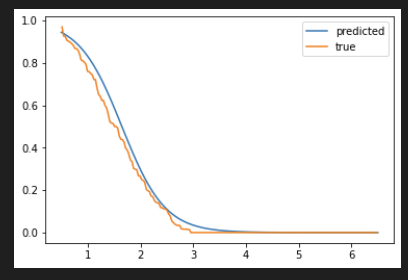

/Users/saketh/Documents/cornell_classes/orie5355/assignments/.venv/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/saketh/Documents/cornell_classes/orie5355/assignments/.venv/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/saketh/Documents/cornell_classes/orie5355/assignments/.venv/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept


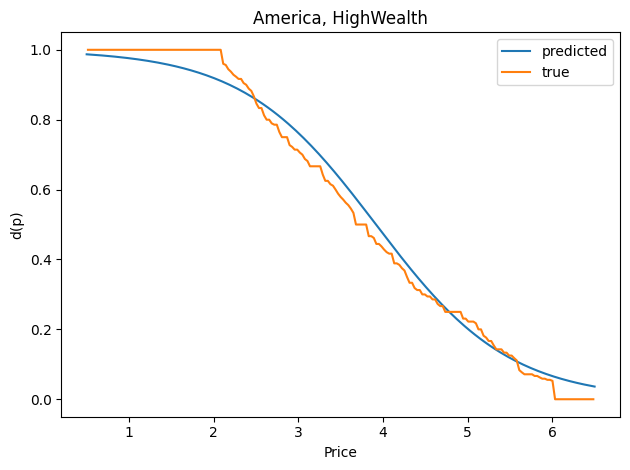

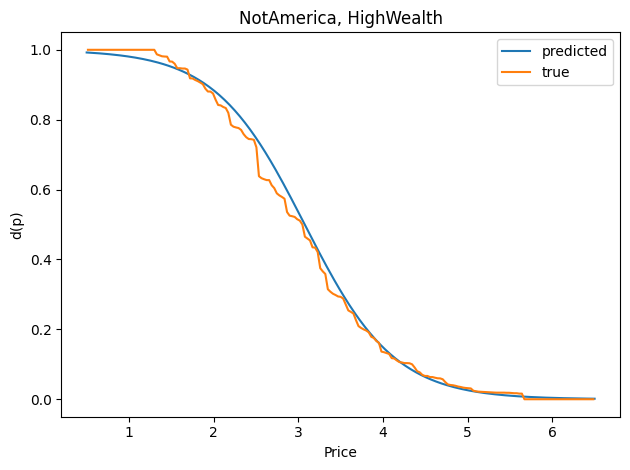

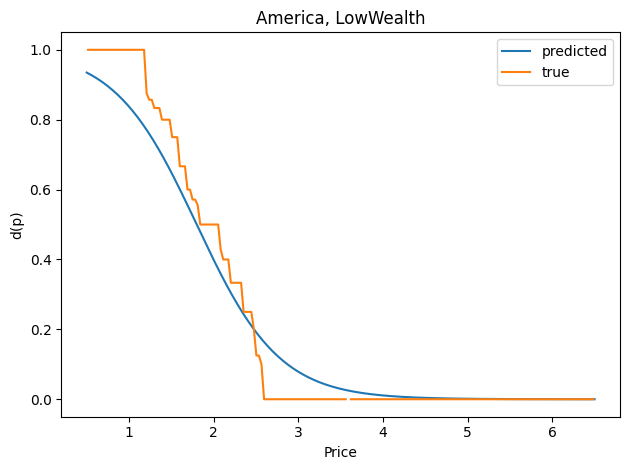

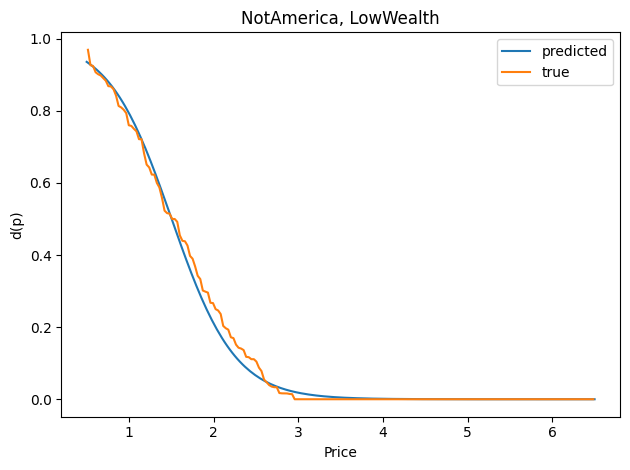

In [20]:
# Price grid for smooth curves
prices_to_predict = np.linspace(df_train['Offered price'].min(),
                                df_train['Offered price'].max(), 200)

# Fit the covariate-aware model on ALL rows
fitted_cov = fit_logistic_regression_demand_with_covariates(df_train)

def plot_group_curve(name, covariate_list, true_curve_df):
    y_pred = [get_prediction_logistic(fitted_cov, p, covariate_list) for p in prices_to_predict]

    # True curve x-axis: bin midpoints (or compute from low/high)
    if 'Price_bin_mid' in true_curve_df.columns:
        tx = true_curve_df['Price_bin_mid'].to_numpy()
    else:
        tx = ((true_curve_df['Price_bin_low'] + true_curve_df['Price_bin_high'])/2.0).to_numpy()
    ty = true_curve_df['Demand_at_price'].to_numpy()

    plt.figure()
    plt.plot(prices_to_predict, y_pred, label='predicted')
    plt.plot(tx, ty, label='true')
    plt.xlabel('Price')
    plt.ylabel('d(p)')
    plt.title(f'{name}')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Four required plots
plot_group_curve('America, HighWealth',
                 ['America','HighWealth'],
                 test_demand_curve_America_HighWealth)

plot_group_curve('NotAmerica, HighWealth',
                 ['NotAmerica','HighWealth'],
                 test_demand_curve_NotAmerica_HighWealth)

plot_group_curve('America, LowWealth',
                 ['America','LowWealth'],
                 test_demand_curve_America_LowWealth)

plot_group_curve('NotAmerica, LowWealth',
                 ['NotAmerica','LowWealth'],
                 test_demand_curve_NotAmerica_LowWealth)


The predicted vs true are similar and as mentioned before, the logistic regression model generalizes to prevent noise in the data to appear.

### 2b) Pricing

<font color='green'> Now, use your code from 1c to output predicted optimal prices, predicted revenue, and the actual revenue using the test data curve, for each covariate combination. Your output should have 4 rows, one for each covariate combination.

For example, we got for one of the covariate combinations:

Group Not America, Low Wealth: Optimal price 1.314070, Predicted Revenue 0.913284, True revenue 0.788442

In [21]:
# Helper: revenue maximization over a grid
def get_revenue_maximizing_price_and_revenue(price_options, demand_predictions):
    price_options = np.asarray(price_options, dtype=float)
    demand_predictions = np.asarray(demand_predictions, dtype=float)
    revenues = price_options * demand_predictions
    idx = int(np.argmax(revenues))
    return float(price_options[idx]), float(revenues[idx])

# Helper: get "true" demand from a test curve at a price (nearest bin midpoint)
def true_demand_from_curve(curve_df: pd.DataFrame, price: float) -> float:
    if 'Price_bin_mid' in curve_df.columns:
        mids = curve_df['Price_bin_mid'].to_numpy()
    else:
        mids = ((curve_df['Price_bin_low'] + curve_df['Price_bin_high'])/2.0).to_numpy()
    i = int(np.argmin(np.abs(mids - price)))
    return float(curve_df.iloc[i]['Demand_at_price'])

# Price grid to search
grid = np.linspace(df_train['Offered price'].min(),
                   df_train['Offered price'].max(), 400)

# Group definitions: (name, covariates list, true curve df)
groups = [
    ("America, HighWealth",    ['America','HighWealth'],    test_demand_curve_America_HighWealth),
    ("NotAmerica, HighWealth", ['NotAmerica','HighWealth'], test_demand_curve_NotAmerica_HighWealth),
    ("America, LowWealth",     ['America','LowWealth'],     test_demand_curve_America_LowWealth),
    ("NotAmerica, LowWealth",  ['NotAmerica','LowWealth'],  test_demand_curve_NotAmerica_LowWealth),
]

rows = []
for name, covs, curve_df in groups:
    preds = [get_prediction_logistic(fitted_cov, p, covs) for p in grid]
    p_star, rev_pred = get_revenue_maximizing_price_and_revenue(grid, preds)
    true_rev = p_star * true_demand_from_curve(curve_df, p_star)
    rows.append({
        "Group": name,
        "Optimal price": p_star,
        "Predicted revenue": rev_pred,
        "True revenue": true_rev
    })

results_p2b = pd.DataFrame(rows)
# Nice formatting for display
display(results_p2b.style.format({
    "Optimal price": "{:.6f}",
    "Predicted revenue": "{:.6f}",
    "True revenue": "{:.6f}",
}))

,Group,Optimal price,Predicted revenue,True revenue
0,"America, HighWealth",3.071429,2.289146,2.111607
1,"NotAmerica, HighWealth",2.409774,1.876295,1.794513
2,"America, LowWealth",1.462406,0.974550,1.169925
3,"NotAmerica, LowWealth",1.206767,0.830888,0.785356


<font color='green'> Suppose each of the 4 covariate combinations makes up an equal part of the population. What would be the resulting revenue achieved at test time if you use the optimal price for each group (so you look at their covariates, and then give them the optimal price for that group).

In other words, this answer should be a single number, the mean of the true revenue of the 4 groups.

In [22]:
mean_true_revenue_equal_mix = results_p2b["True revenue"].mean()
print(f"Mean test-time revenue with per-group optimal prices (equal mix): {mean_true_revenue_equal_mix:.6f}")

Mean test-time revenue with per-group optimal prices (equal mix): 1.465350


<font color='green'> Comment on your outputs in no more than 3 sentences. What is the effect of using different prices for different covariate groups?

Using different prices for each covariate group raises revenue because segments differ in both baseline demand and price sensitivity. High-wealth and/or America customers support higher optimal prices, while low-wealth or non-America groups require lower prices to convert. The mean of the four true revenues quantifies the personalization gain over a single one-size-fits-all price.

# Problem 3: Pricing under capacity constraints

Now, we are going to build up to implementing the Bellman equation approach discussed in class, to price a single copy of an item to be sold over $T$ time periods. For simplicity, we will use `test_demand_curve` as $d(p)$. 

In [23]:
price_options = list(test_demand_curve.Price_bin_mid)
demand_predictions = list(test_demand_curve.Demand_at_price)

### 3a) Implementing one step of the Bellman equation

Recall the "Bellman equation" taught in class. Suppose we have 1 copy of the item at time $t$. Then, my expected revenue given I price the item at $p_t$ is:
$$ V_t = d(p_t)p_t + (1 - d(p_t))V_{t+1}$$

<font color='green'> Implement the following function that returns optimal price $p_t$ and the resulting value $V_t$, given the demand curve and $V_{t+1}$. 

For example, we find that the output of the following function call is: (2.083, 1.1922434210526316)

`get_single_step_revenue_maximizing_price_and_revenue(0, price_options, demand_predictions)`

In [24]:
def get_single_step_revenue_maximizing_price_and_revenue(Vtplus1, price_options, demand_predictions):
    """
    One-step Bellman optimization with 1 unit of inventory.
    Maximizes:  V_t(p) = d(p)*p + (1 - d(p)) * V_{t+1}

    Args:
        Vtplus1: scalar value function at next period (V_{t+1})
        price_options: iterable of candidate prices p
        demand_predictions: iterable of d(p) for the same order of price_options

    Returns:
        (p_t_star, V_t_star)
    """
    P = np.asarray(price_options, dtype=float)
    D = np.asarray(demand_predictions, dtype=float)
    values = D * P + (1.0 - D) * float(Vtplus1)
    idx = int(np.argmax(values))
    return float(P[idx]), float(values[idx])

p_t, V_t = get_single_step_revenue_maximizing_price_and_revenue(0, price_options, demand_predictions)
print(p_t, V_t)


2.083 1.1922434210526316


### 3b) Calculating prices over time


<font color='green'> Implement the following function that returns a list (of length $T$) of optimal prices for each time period, and a expected revenue number for those prices.
    
Hint: your function should loop through each time step, _starting_ at time $t=T-1$ (the last time period, since the first time period is time $t=0$). Each iteration of the loop should call the function from part 3a. Recall that we can define $V_T = 0$, since even if the item is unsold at time $T$, we have finished trying to sell it.

In [25]:
def get_prices_over_time_and_expected_revenue(prices, demand_predictions, T):
    """
    Backward-induction with 1 unit of inventory for T periods.
    Returns:
      - list of optimal prices p_t for t=0..T-1
      - expected revenue V_0
    """
    V_next = 0.0        # V_T = 0
    p_opt  = [None]*T   # to store p_t
    V_list = [None]*T   # optional, stores V_t at each t

    # Work backward: t = T-1, T-2, ..., 0
    for t in range(T-1, -1, -1):
        p_t, V_t = get_single_step_revenue_maximizing_price_and_revenue(V_next, prices, demand_predictions)
        p_opt[t] = p_t
        V_list[t] = V_t
        V_next = V_t

    # V_0 is V_list[0]
    return p_opt, float(V_list[0])


<font color='green'> Plot a line plot for your optimal prices over time when $T=100$ and $T=10$. Also print out the expected revenue using these prices and for each $T$. 

For example, when $T=100$, we find that prices[0] = 5.822, prices[90] = 4.224, and that revenue = 5.2287

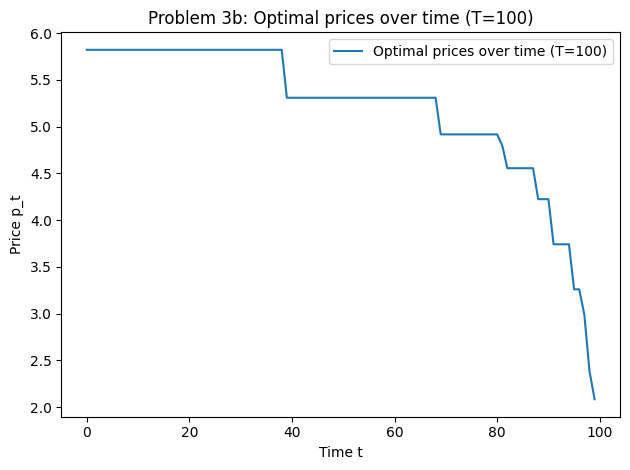

T=100: p[0] = 5.822, p[90] = 4.224, expected revenue = 5.2287


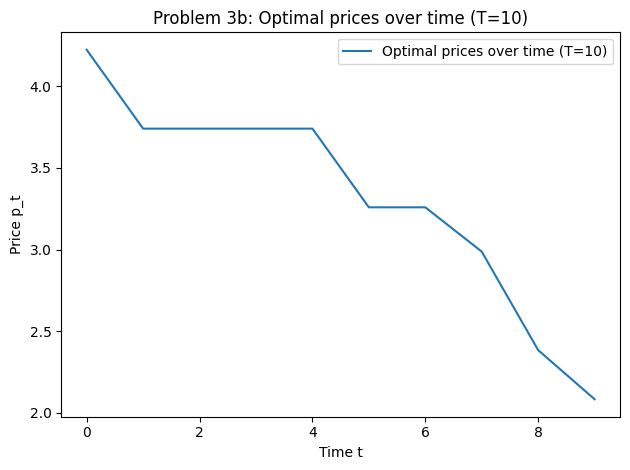

T=10: p[0] = 4.224, p[5] = 3.259, expected revenue = 3.1977


In [26]:
# Convenience plotting helper
def plot_prices_over_time(p_list, T, title_suffix=""):
    plt.figure()
    plt.plot(range(T), p_list, label=f'Optimal prices over time (T={T})')
    plt.xlabel('Time t')
    plt.ylabel('Price p_t')
    plt.title(f'Problem 3b: Optimal prices over time (T={T}){title_suffix}')
    plt.legend()
    plt.tight_layout()
    plt.show()

# --- Run for T=100 and T=10 using the test curve as d(p) ---
prices = list(test_demand_curve['Price_bin_mid'])      # candidate price options
demands = list(test_demand_curve['Demand_at_price'])   # d(p) for those options

# T = 100
prices_T100, revenue_T100 = get_prices_over_time_and_expected_revenue(prices, demands, 100)
plot_prices_over_time(prices_T100, 100)
print(f"T=100: p[0] = {prices_T100[0]:.3f}, p[90] = {prices_T100[90]:.3f}, expected revenue = {revenue_T100:.4f}")

# T = 10
prices_T10, revenue_T10 = get_prices_over_time_and_expected_revenue(prices, demands, 10)
plot_prices_over_time(prices_T10, 10)
print(f"T=10: p[0] = {prices_T10[0]:.3f}, p[5] = {prices_T10[5]:.3f}, expected revenue = {revenue_T10:.4f}")

### 3c) [Bonus, 2 points] Prices over time with multiple copies

<font color='green'> Now, suppose that you have $K$ copies of the item, that you must sell over a time period $T$. Implement the two-dimensional dynamic program as discussed in class. Plot a line plot where the X axis is time as in 3b, but now you have $K$ lines where each line indicates the price at time $T$ if you have $K$ items left. 
    
Hint: As in 3a and 3b, you may find it useful to first optimize the price $p_{t,k}$ given the values $V_{t+1, k}$, $V_{t+1, k-1}$. Then, have a 2nd function that loops through $t, k$ in an appropriate order. 

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Reuse the test-time demand curve as d(p) like earlier:
# price_options = list(test_demand_curve['Price_bin_mid'])
# demand_predictions = list(test_demand_curve['Demand_at_price'])

def optimize_price_given_values(V_next_k, V_next_kminus1, price_options, demand_predictions):
    """
    One-step optimization when we have k items at time t and values known at t+1:
      V_{t+1,k} (if we don't sell) and V_{t+1,k-1} (if we do sell).
    We maximize:
      V_t(p) = d(p)*[p + V_{t+1,k-1}] + (1 - d(p))*V_{t+1,k}
    Returns: (p*_t,k, V_t,k)
    """
    P = np.asarray(price_options, dtype=float)
    D = np.asarray(demand_predictions, dtype=float)
    values = D * (P + float(V_next_kminus1)) + (1.0 - D) * float(V_next_k)
    idx = int(np.argmax(values))
    return float(P[idx]), float(values[idx])

def get_prices_over_time_and_expected_revenue_multi(price_options, demand_predictions, T: int, K: int):
    """
    Two-dimensional DP for multiple copies.
    V[t, k] = optimal expected revenue starting at time t with k items remaining.
    Policy stores price p_{t,k} that attains V[t, k].

    Args:
      price_options, demand_predictions: arrays defining d(p)
      T: number of time periods
      K: inventory (copies)

    Returns:
      policy_prices: shape (T, K+1), where column k holds price p_{t,k}; p_{t,0} is np.nan
      V0K: expected revenue V[0, K]
      V: full value table (shape (T+1, K+1)) if you want to inspect
    """
    price_options = list(price_options)
    demand_predictions = list(demand_predictions)

    # Value table: times 0..T, inventory 0..K
    V = np.zeros((T+1, K+1), dtype=float)
    policy = np.full((T, K+1), np.nan, dtype=float)

    # Boundary conditions:
    # - V[T, k] = 0 for all k (time is over)
    # - V[t, 0] = 0 for all t (no items to sell)
    # Backward induction on t, forward on k>=1
    for t in range(T-1, -1, -1):
        for k in range(1, K+1):
            p_star, V_tk = optimize_price_given_values(
                V_next_k      = V[t+1, k],
                V_next_kminus1= V[t+1, k-1],
                price_options = price_options,
                demand_predictions = demand_predictions
            )
            V[t, k] = V_tk
            policy[t, k] = p_star

    return policy, float(V[0, K]), V

def plot_multi_inventory_prices(policy_prices, T: int, K: int, title_suffix=""):
    """
    Plot K lines: price at time t if k items are left (for k=1..K).
    X-axis is time t (0..T-1).
    """
    plt.figure()
    for k in range(1, K+1):
        plt.plot(range(T), policy_prices[:, k], label=f'k={k}')
    plt.xlabel('Time t')
    plt.ylabel('Price p_{t,k}')
    plt.title(f'Problem 3c: Optimal prices over time for multiple copies (K={K}, T={T}){title_suffix}')
    plt.legend()
    plt.tight_layout()
    plt.show()


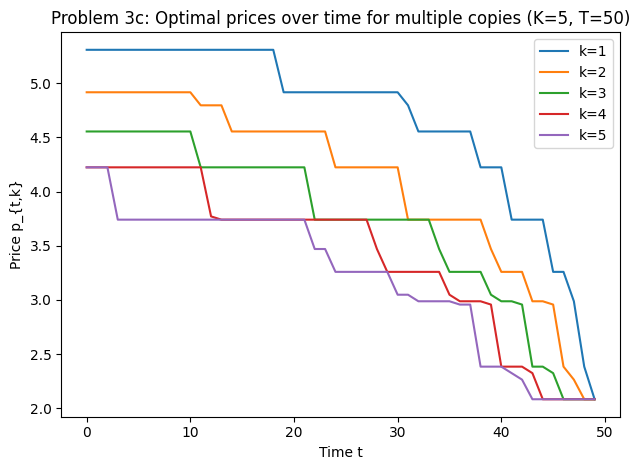

Expected revenue V[0, 5] with optimal policy: 18.741178


In [28]:
# === Example run (you can change K and T) ===

# Use the provided test curve:
price_options = list(test_demand_curve['Price_bin_mid'])
demand_predictions = list(test_demand_curve['Demand_at_price'])

T = 50
K = 5

policy_prices, V0K, _ = get_prices_over_time_and_expected_revenue_multi(
    price_options, demand_predictions, T=T, K=K
)

plot_multi_inventory_prices(policy_prices, T, K)
print(f"Expected revenue V[0, {K}] with optimal policy: {V0K:.6f}")
